# Building yield curves from market data

In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import scipy.interpolate

In [2]:
class Bond:
    principal = 0.
    maturity = 1
    coupon = 0.
    fixings = []
    price = 0.
    def __init__(self, price, princ, mat, coup, fix):
        self.principal = princ
        self.coupon = coup
        self.fixings = fix
        self.maturity = mat
        self.price = price

## USD bonds market data

In [3]:
bonds = [Bond(98.16, 100, 14, 0, []), 
         Bond(95.58, 100, 30, 5, [14]), 
         Bond(91.24, 100, 45, 5, [14, 30]), 
         Bond(87.29, 100, 60, 5, [14, 30, 45]), 
         Bond(68.12, 100, 90, 5, [30, 60])]

$$PV_{bond} = \Sigma_{1}^{n} N_{coupon}*e^{-r_{USD}^it_i} + N_{principal}*e^{- r_{USD}^nT_n}$$

$$PV_{Zero Coupon Bond} = N_{principal}*e^{- r_{USD}T}$$

$$r_{USD} = -\frac{ln(\frac{PV_{Zero Coupon Bond}}{N_{principal}})}{T}$$

## Bootstrapping

In [4]:
def yield_usd(zc_bond_price, principal, t):
    return - np.log(zc_bond_price / principal) / t

In [5]:
usd_rates = {}

convert to zero coupon
$$PV_{bond} - \Sigma_{i=1}^{n-1} N_{coupon}*e^{-r_{USD}^iT_i} = N_{principal}*e^{- r_{USD}^nT_n}$$

In [6]:
def to_zero_coupon_price(bond):
    price = bond.price
    for f in bond.fixings:
        price -= bond.coupon * np.exp(- usd_rates[f] * f / 360.)
    return price

$$PV_{bond} = N_{coupon}*e^{-r_{USD}^1T_1} + N_{principal}*e^{- r_{USD}^2T_2}$$

In [7]:
for bond in bonds:
    usd_rates[bond.maturity] = yield_usd(to_zero_coupon_price(bond), 
                                         bond.principal, 
                                         bond.maturity / 360.)

In [8]:
sorted_usd_rates = collections.OrderedDict(sorted(
        map(lambda (k,v): (k,v), usd_rates.iteritems())))

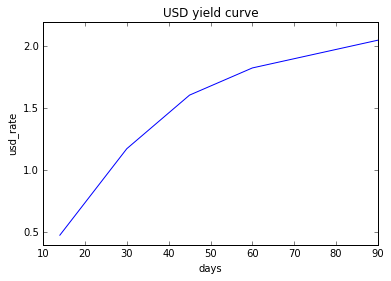

In [9]:
plt.title('USD yield curve')
plt.xlabel('days')
plt.ylabel('usd_rate')
plt.plot(sorted_usd_rates.keys(), sorted_usd_rates.values())

## Interpolation of USD curve

In [20]:
usd_yield_curve = scipy.interpolate.interp1d(sorted_usd_rates.keys(), 
                                             sorted_usd_rates.values())

$$F=Se^{(r_{EUR}-r_{USD})t}$$

$$r_{EUR} = r_{USD} + \frac{ln(\frac{F}{S})}{t}$$

In [11]:
def yield_eur(fut_price, spt_price, t, yield_usd):
    return yield_usd + np.log(fut_price / spt_price) / t

## FxFutures market data

In [12]:
futures_prices = {15:1.10375, 30:1.1057, 45:1.1061, 60:1.1063, 72:1.1069, 85:1.107}
spot = 1.1004

## Interpolation of EUR curve

In [13]:
eur_rates = collections.OrderedDict(sorted(
        map(lambda (tenor, price): 
            (tenor, yield_eur(price, spot, tenor / 360., usd_yield_curve(tenor))), 
            futures_prices.iteritems())))

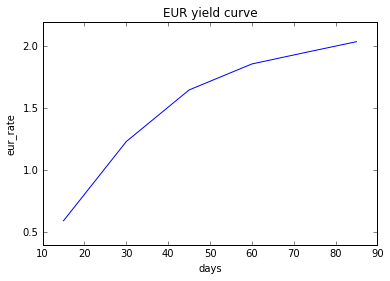

In [14]:
plt.title('EUR yield curve')
plt.xlabel('days')
plt.ylabel('eur_rate')
plt.plot(eur_rates.keys(), eur_rates.values())

In [15]:
eur_yield_curve = scipy.interpolate.interp1d(eur_rates.keys(), eur_rates.values())

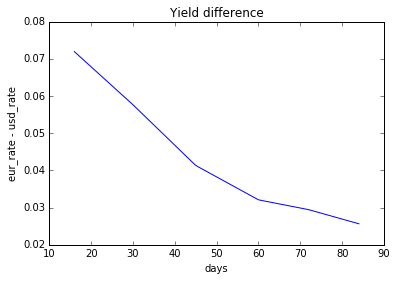

In [16]:
x = np.linspace(16, 84, num=100, endpoint=True)
plt.title('Yield difference')
plt.xlabel('days')
plt.ylabel('eur_rate - usd_rate')
plt.plot(x, eur_yield_curve(x) - usd_yield_curve(x))

## Pricing forward

$$F = S e^{(r_{EUR} - r_{USD}) t}$$

In [17]:
def forward_price(spt_price, usd_rate, eur_rate, t):
    return spt_price * np.exp((eur_rate - usd_rate) * t)

In [18]:
print forward_price(spot, usd_yield_curve(37), eur_yield_curve(37), 37. / 360.)

1.10607389738
